In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib
import keras
import keras_nlp

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint
from wordcloud import WordCloud


warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 700)


TRAIN_DATA_PATH = "/kaggle/input/nlp-tweets-data/train.csv"
TEST_DATA_PATH = "/kaggle/input/nlp-tweets-data/test.csv"



2024-04-02 10:54:53.522469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 10:54:54.286207: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 10:54:54.290496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 10:54:57.268127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


/home/stanislav/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## EDA

### Visualization utils

In [2]:


def plot_missing_values(df, title="Missing Values in Data", colormap="magma"):
    missing_percentage = df.isnull().mean() * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette=colormap)
    
    plt.xlabel('Missing Values % ', fontsize=14)
    plt.ylabel('Column', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(np.linspace(0, 50, 10 + 1))
    
    for i, percentage in enumerate(missing_percentage.values):
        plt.text(percentage + 0.5, i, f'{percentage:.2f}%', fontsize=12, va='center')
    
    plt.show()
    
    
def plot_column_counts(df, column_name, title, display_k=10, colormap="viridis", figsize=(12, 8)):
    '''
    Function to display bar plots of counts of a column in a DataFrame
    
    Inputs:
        df: DataFrame
            The DataFrame containing the data
        column_name: str
            Name of the column to plot
        display_k: int, default=10
            Number of top values to plot
    '''
    column_counts = df[column_name].value_counts()[:display_k]
    
    # Plot the bar plot using Seaborn
    plt.figure(figsize=figsize)
    sns.barplot(x=column_counts.values, y=column_counts.index, palette=colormap,)
    
    plt.xlabel('Counts', fontsize=16)
    plt.ylabel(column_name, fontsize=13)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.show()
    

def generate_wordcloud(df, column_name, title, colormap="magma"):
    '''
    Function to generate and display a word cloud for a column in a DataFrame
    
    Inputs:
        df: DataFrame
            The DataFrame containing the data
        column_name: str
            Name of the column to generate word cloud from
    '''
    # Concatenate all words in the column
    text = ' '.join(df[column_name].dropna().astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap=colormap).generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(13, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axis
    plt.title(title, fontsize=16)
    plt.show()
    
    
def plot_binary_target_distribution(df, target_column):
    '''
    Function to plot the distribution of a binary target variable using Seaborn
    
    Inputs:
        df: DataFrame
            The DataFrame containing the data
        target_column: str
            Name of the binary target column
    '''
    # Plot the distribution of the binary target variable using Seaborn
    plt.figure(figsize=(10, 7))
    ax = sns.countplot(data=df, x=target_column, palette='magma')
    plt.title(f'Distribution of {target_column}', fontsize=16)
    plt.xlabel('Target Variable', fontsize=14)
    plt.yticks(np.linspace(0, 10000, 10 + 1))
    plt.ylabel('Count', fontsize=14)
    
    # Add percentage labels on top of each bar
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height / total:.1%}', ha='center', fontsize=15)
    
    plt.show()
    
    

In [3]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7613 entries, 0 to 7612

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   id        7613 non-null   int64 

 1   keyword   7552 non-null   object

 2   location  5080 non-null   object

 3   text      7613 non-null   object

 4   target    7613 non-null   int64 

dtypes: int64(2), object(3)

memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3263 entries, 0 to 3262

Data columns (total 4 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   id        3263 non-null   int64 

 1   keyword   3237 non-null   object

 2   location  2158 non-null   object

 3   text      3263 non-null   object

dtypes: int64(1), object(3)

memory usage: 102.1+ KB


In [6]:
train_df.head(3)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1


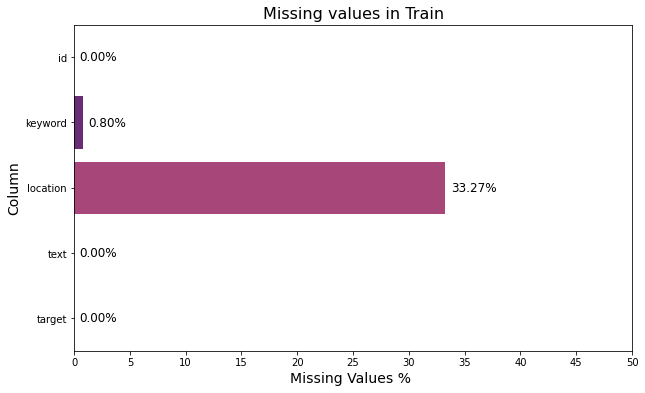

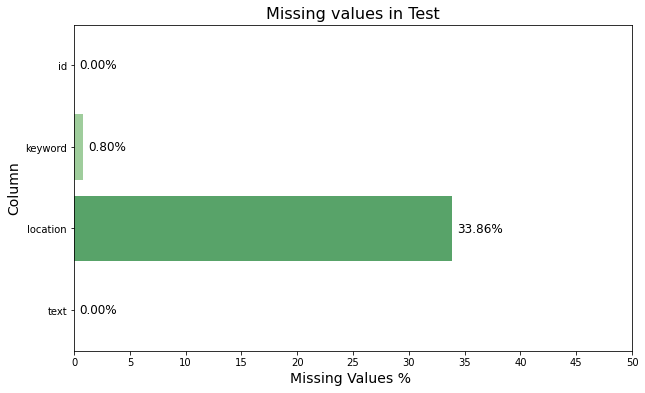

In [7]:
plot_missing_values(train_df, "Missing values in Train")
plot_missing_values(test_df, "Missing values in Test", colormap="Greens")

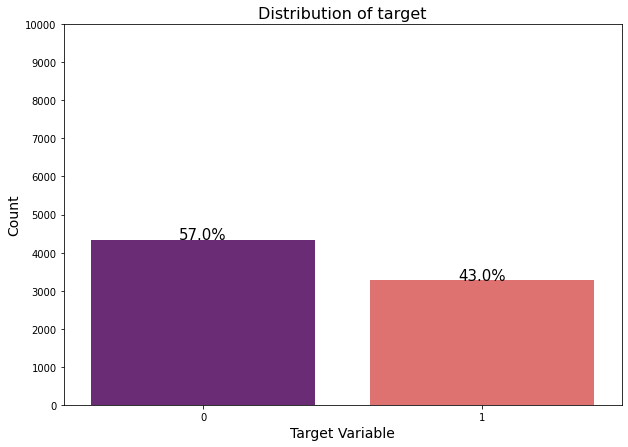

In [8]:
plot_binary_target_distribution(train_df, "target")

### Location column

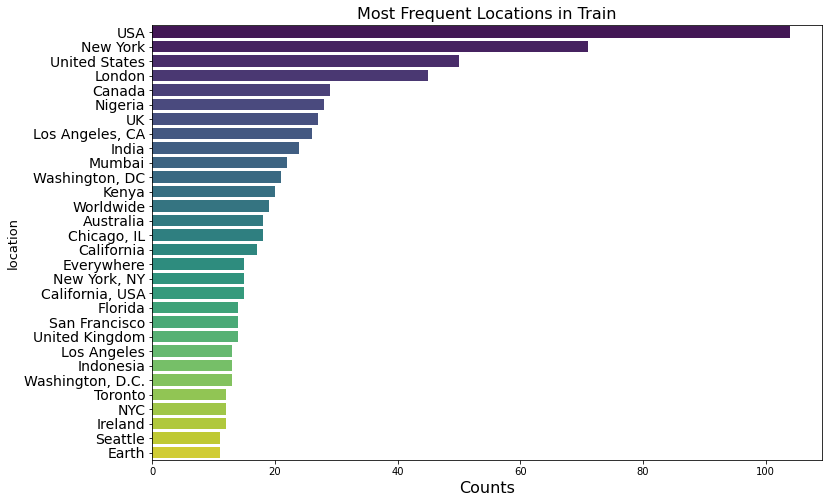

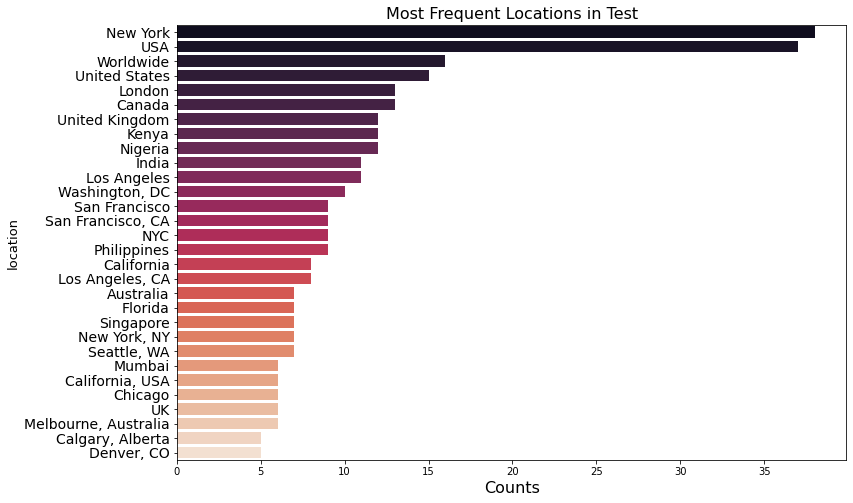

In [9]:
plot_column_counts(train_df, column_name="location",
                   title="Most Frequent Locations in Train",
                   display_k=30,
                   colormap="viridis")


plot_column_counts(test_df, column_name="location",
                   title="Most Frequent Locations in Test",
                   display_k=30,
                   colormap="rocket")


In [10]:
train_df["location"].value_counts()[-20:]

Paulton, England                  1
Johannesburg                      1
Alvin, TX                         1
Wilbraham, MA                     1
Jerseyville, IL                   1
The Citadel, Oldtown, Westeros    1
Trackside California              1
he/him or she/her (ask)           1
Some pum pum                      1
SEA Server                        1
Waco, Texas                       1
todaysbigstock.com                1
buenos aires argentina            1
everydaynigerian@gmail.com        1
Surulere Lagos,Home Of Swagg      1
MontrÌ©al, QuÌ©bec                1
Montreal                          1
ÌÏT: 6.4682,3.18287               1
Live4Heed??                       1
Lincoln                           1
Name: location, dtype: int64

In [11]:
test_df["location"].value_counts()[-20:]

Raleigh                           1
norton                            1
Dunedin, New Zealand              1
@ArgentinaLiars ?| willbradley    1
Virginia                          1
festac,Lagos,Nigeria              1
At Grandmother Willow's           1
|Elsmere| Wilmington, DE.         1
Curitiba-PR                       1
globetrotter                      1
Roanoke, VA                       1
Between Manchester and Lille.     1
Phoenix, AZ                       1
Subconscious LA                   1
#Global                           1
Medford, NJ                       1
Quezon City                       1
LanÌ¼s                            1
USA,Washington,Seattle            1
Brussels, Belgium                 1
Name: location, dtype: int64

    Observations:
        1) Location columns has about 33% values missing which is quite high rate of NAN's values
        
        2) Values are not in the same granularity level. We have cities, countries, country + city pairs and different tags. This means, that this columns is hard to parse, encode and process as we don't have a clear 
        interpretation what location means. It could be anything from country to email (as you can see above).
        
        3) Least common locations are weird and not interpretable. We can see emails, incorrect spelling and just some garbage in values
        
Overall, I would say, that I will drop this feature for now since it seems to be unpromissing because of quality and consistency of values in location column.
     

### Keyword column


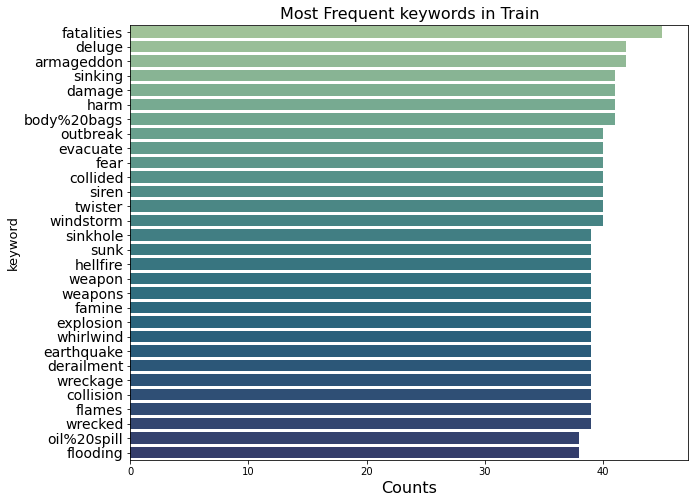

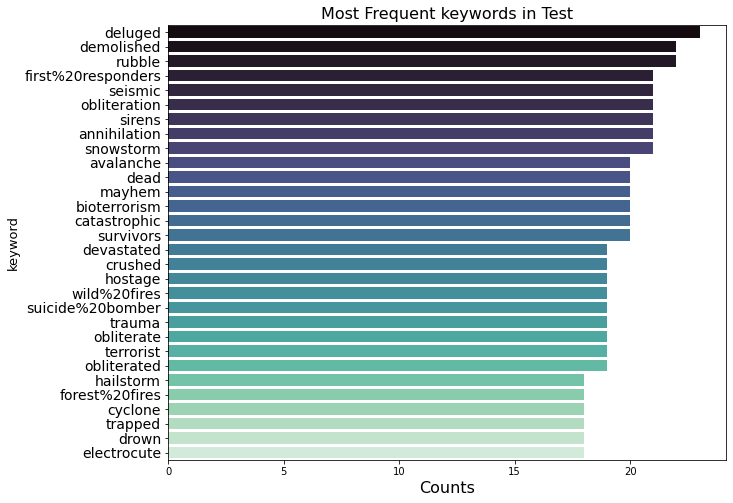

In [13]:
plot_column_counts(train_df, column_name="keyword",
                   title="Most Frequent keywords in Train",
                   display_k=30,
                   colormap="crest",
                   figsize=(10, 8))


plot_column_counts(test_df, column_name="keyword",
                   title="Most Frequent keywords in Test",
                   display_k=30,
                   colormap="mako",
                   figsize=(10, 8))

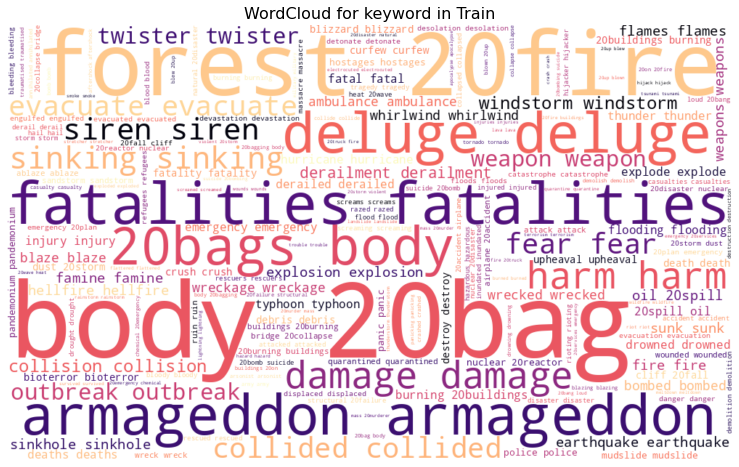

In [14]:
generate_wordcloud(train_df, "keyword",
                   title="WordCloud for keyword in Train")


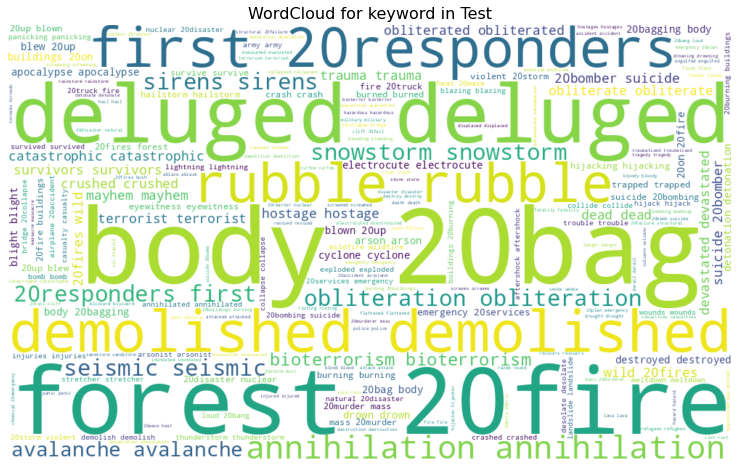

In [15]:
generate_wordcloud(test_df, "keyword", 
                   title="WordCloud for keyword in Test",
                   colormap="viridis")

### Tweets content

In [16]:
print("Examples of tweets in Train:\n\n")

for i in range(10):
    print("Tweet #", i + 1, train_df.iloc[i]["text"], "\n")

print("\n\nExamples of tweets in Test:\n\n")

for i in range(10):
    print("Tweet #", i + 1, test_df.iloc[i]["text"], "\n")

Examples of tweets in Train:





Tweet # 1 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 



Tweet # 2 Forest fire near La Ronge Sask. Canada 



Tweet # 3 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 



Tweet # 4 13,000 people receive #wildfires evacuation orders in California  



Tweet # 5 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  



Tweet # 6 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 



Tweet # 7 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 



Tweet # 8 I'm on top of the hill and I can see a fire in the woods... 



Tweet # 9 There's an emergency evacuation happening now in the building across the street 



Tweet # 10 I'm afraid that the tornado is coming to our area... 







Examples of tweets in T

### Cleaning Text 

In [17]:
#%%writefile text_cleaning_utils.py

import re
import string
import nltk
from nltk.corpus import stopwords


def remove_url(text):
    return re.sub(r'https?:\S*', '', text)

def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*', '', text)
    return re.sub(r'#\S*', '', text)


def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)


def remove_numbers(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

def remove_stopwords(text):
    stop_words = set(stopwords.words('english')).union(list("qwertyiopasdfghjklzxcvbnm"))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])



def clean_text(text):

    lowered_text = text.lower()
    removed_tags_text = remove_mentions_and_tags(lowered_text)
    removed_urls_text = remove_url(removed_tags_text)
    removed_spec_chars_text = remove_special_characters(removed_urls_text)
    removed_numbers_text = remove_numbers(removed_spec_chars_text)

    cleaned_text = remove_stopwords(remove_punctuation(removed_numbers_text).strip())

    return cleaned_text
    


In [18]:
train_df["text_cleaned"] = train_df["text"].apply(clean_text)
test_df["text_cleaned"] = test_df["text"].apply(clean_text)

In [19]:
train_df.head(3)

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected


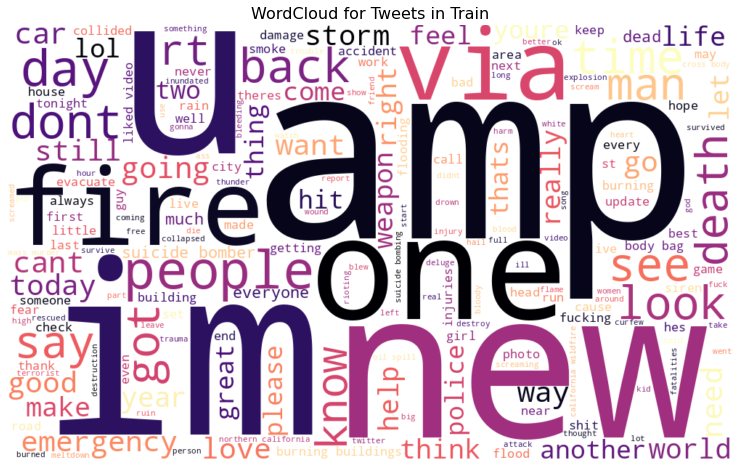

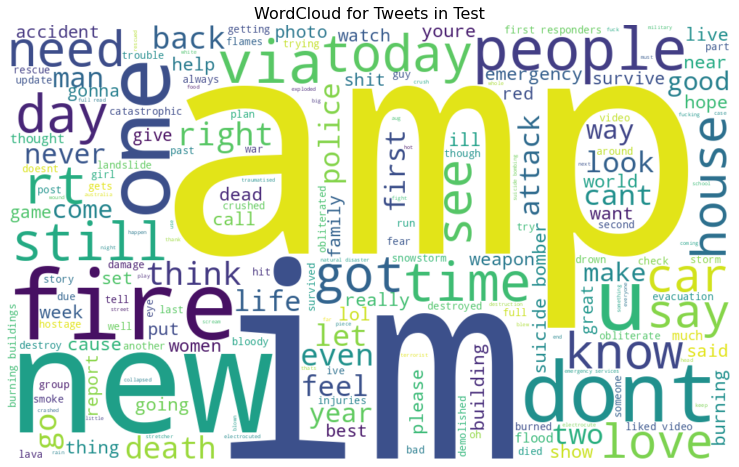

In [20]:
generate_wordcloud(train_df, "text_cleaned", 
                   title="WordCloud for Tweets in Train")


generate_wordcloud(test_df, "text_cleaned", 
                   title="WordCloud for Tweets in Test",
                   colormap="viridis")

### Saving cleaned data


In [22]:
cleaned_train_df = train_df[["id", "text_cleaned", "target"]]
cleaned_test_df  = test_df[["id", "text_cleaned"]]


cleaned_train_df.to_csv("data/cleaned_train.csv", index=False)
cleaned_test_df.to_csv("data/cleaned_test.csv", index=False)

## Training Model

In [2]:

#load clean data
full_train_df = pd.read_csv("/kaggle/input/cleaned-nlp-tweets/cleaned_train.csv")
full_train_df.dropna(inplace=True)


print("Train Data shape :", full_train_df.shape)
full_train_df.head()

Train Data shape : (7610, 3)


,id,text_cleaned,target
0,1,deeds reason may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,people receive evacuation orders california,1
4,7,got sent photo ruby smoke pours school,1


In [3]:
full_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7610 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7610 non-null   int64 
 1   text_cleaned  7610 non-null   object
 2   target        7610 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 237.8+ KB


### Splitting data

In [4]:
shuffled_train_df = full_train_df.sample(frac=1,
                                    random_state=42,
                                    replace=False)



train_data_split_df = shuffled_train_df[ : 6000]
val_data_split_df = shuffled_train_df[6000 : 6800]
test_data_split_df = shuffled_train_df[6800: ]

train_split_ids = train_data_split_df["id"]
val_split_ids = val_data_split_df["id"]
test_split_ids = val_data_split_df["id"]


print("Train  split shape: ", train_data_split_df.shape)
print("Validation split shape: ", val_data_split_df.shape)
print("Test  split shape: ", test_data_split_df.shape)

Train  split shape:  (6000, 3)
Validation split shape:  (800, 3)
Test  split shape:  (810, 3)


### Establish Baseline: TF-iDF + Logistic Regression

In [5]:
TF_MAX_FEATURES = 2000
TF_MAX_DF=0.93
TF_MIN_DF=0.00001


In [6]:

tfidf_vectorizer = TfidfVectorizer(
                             max_features=TF_MAX_FEATURES,
                             max_df=TF_MAX_DF,
                             min_df=TF_MIN_DF,
                             )


In [7]:
tfidf_vectorizer.fit(train_data_split_df["text_cleaned"])

TfidfVectorizer(max_df=0.93, max_features=2000, min_df=1e-05)

In [8]:
train_tfidf_matrix  = tfidf_vectorizer.transform(train_data_split_df["text_cleaned"]).toarray()
val_tfidf_matrix = tfidf_vectorizer.transform(val_data_split_df["text_cleaned"]).toarray()
test_tfidf_matrix = tfidf_vectorizer.transform(test_data_split_df["text_cleaned"]).toarray()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score



logreg = LogisticRegression(random_state=42)

logreg.fit(train_tfidf_matrix, train_data_split_df["target"])

LogisticRegression(random_state=42)

In [10]:

def evaluate_model(model, train_data, val_data, test_data):
    # Predictions
    train_preds = np.round(model.predict(train_data[0]))
    val_preds = np.round(model.predict(val_data[0]))
    test_preds = np.round(model.predict(test_data[0]))
    
    # F1 scores
    train_f1 = f1_score(train_data[1], train_preds)
    val_f1 = f1_score(val_data[1], val_preds)
    test_f1 = f1_score(test_data[1], test_preds)
    
    # Accuracy scores
    train_acc = accuracy_score(train_data[1], train_preds)
    val_acc = accuracy_score(val_data[1], val_preds)
    test_acc = accuracy_score(test_data[1], test_preds)
    
    # Print results
    print("MODEL: ", str(model))
    print("\n======ACCURACY==========\n")
    print("Train Accuracy Score: ", train_acc)
    print("Validation Accuracy Score: ", val_acc)
    print("Test Accuracy  Score: ", test_acc)

    print("\n======F1-Score==========\n")
    print("Train F1 Score: ", train_f1)
    print("Validation F1 Score: ", val_f1)
    print("Test F1 Score: ", test_f1)


evaluate_model(logreg, 
               (train_tfidf_matrix, train_data_split_df["target"]), 
               (val_tfidf_matrix, val_data_split_df["target"]), 
               (test_tfidf_matrix, test_data_split_df["target"]))


MODEL:  LogisticRegression(random_state=42)

======ACCURACY==========

Train Accuracy Score:  0.8565
Validation Accuracy Score:  0.78875
Test Accuracy  Score:  0.782716049382716

======F1-Score==========

Train F1 Score:  0.8154340836012862
Validation F1 Score:  0.7287319422150883
Test F1 Score:  0.7349397590361445


### Saving baseline pipeline

In [11]:
baseline_pipeline = Pipeline([
    ('TF-IDF', tfidf_vectorizer),
    ('Logistic Regression', logreg)
])


joblib.dump(baseline_pipeline, "tfidf_logreg_baseline.joblib")



['tfidf_logreg_baseline.joblib']

### Baseline 2: TF-iDf + Simple Neural Net

In [12]:

baseline_nn_model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=(TF_MAX_FEATURES,)),
         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
       
], name="baseline_shallow_neuralnet")


baseline_nn_model.summary()

Model: "baseline_shallow_neuralnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,577 (252.25 KB)

 Trainable params: 64,577 (252.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:



baseline_nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), 
                          metrics=["accuracy"],
                          loss="binary_crossentropy")

baseline_nn_history = baseline_nn_model.fit(train_tfidf_matrix, train_data_split_df["target"].values.reshape(-1, 1),
                       batch_size=256,
                       epochs=30,
                       validation_data=(val_tfidf_matrix, val_data_split_df["target"].values.reshape(-1, 1)),
                      )

Epoch 1/30
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5392 - loss: 0.6920 

I0000 00:00:1711982174.222988      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711982174.240484      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5411 - loss: 0.6919

W0000 00:00:1711982177.505662      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5415 - loss: 0.6918 - val_accuracy: 0.5825 - val_loss: 0.6867
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5740 - loss: 0.6874 - val_accuracy: 0.5750 - val_loss: 0.6813
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5795 - loss: 0.6826 - val_accuracy: 0.5750 - val_loss: 0.6751
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5814 - loss: 0.6768 - val_accuracy: 0.5750 - val_loss: 0.6682
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5814 - loss: 0.6714 - val_accuracy: 0.5750 - val_loss: 0.6602
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5805 - loss: 0.6660 - val_accuracy: 0.5788 - val_loss: 0.6511
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5860 - loss: 0.6589 - val_accuracy: 0.6000 - val_loss: 0.6399
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6025 - loss: 0.6490 - val_accuracy: 0.6413 - val_loss: 0.6269
E

In [16]:

evaluate_model(baseline_nn_model, 
               (train_tfidf_matrix, train_data_split_df["target"]), 
               (val_tfidf_matrix, val_data_split_df["target"]), 
               (test_tfidf_matrix, test_data_split_df["target"]))


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

MODEL:  <Sequential name=baseline_shallow_neuralnet, built=True>



======ACCURACY==========



Train Accuracy Score:  0.8558333333333333

Validation Accuracy Score:  0.7775

Test Accuracy  Score:  0.782716049382716



======F1-Score==========



Train F1 Score:  0.8133764832793959

Validation F1 Score:  0.7129032258064516

Test F1 Score:  0.7325227963525835


In [17]:
baseline_nn_model.save("baseline_nn_model.keras")

### DistilledBERT finetuning

In [18]:
X_train, y_train = train_data_split_df["text_cleaned"].values, train_data_split_df["target"].values
X_val, y_val = val_data_split_df["text_cleaned"].values, val_data_split_df["target"].values
X_test, y_test = test_data_split_df["text_cleaned"].values, test_data_split_df["target"].values

In [19]:
PRETRAINED_MODEL =  "distil_bert_base_en_uncased"



preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(PRETRAINED_MODEL,
                                                             sequence_length=150,
                                                             name="bert_preprocessor")



# #output - logits
bert_classifier = keras_nlp.models.DistilBertClassifier.from_preset(PRETRAINED_MODEL,
                                                                    preprocessor=preprocessor,
                                                                      num_classes=1)


Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...

Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...

Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...

Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...

Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...


In [20]:
bert_classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,954,241 (255.41 MB)

 Trainable params: 66,954,241 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
OPTIMIZER = tf.keras.optimizers.Adam(2e-6)
METRICS = ["accuracy"]


bert_classifier.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

In [20]:
backup_restore_callback = keras.callbacks.BackupAndRestore(backup_dir="train_backups/")


checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="train_checkpoints/bert_best_checkpoint.keras",
                                      save_weights_only=False,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=2,
                                                verbose=1)

In [23]:
bert_classifier.fit(X_train, y_train, 
               validation_data=(X_val, y_val),
               batch_size=32, epochs=20,
                callbacks=[checkpoint_callback, backup_restore_callback, early_stopping])




Epoch 1/20


W0000 00:00:1711923922.184962      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.5742 - loss: 0.6767

W0000 00:00:1711923999.564179      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1711924002.853322      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to train_checkpoints/bert_best_checkpoint.keras

188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 461ms/step - accuracy: 0.5743 - loss: 0.6765 - val_accuracy: 0.7500 - val_loss: 0.5486

Epoch 2/20

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7757 - loss: 0.5129

Epoch 2: val_accuracy improved from 0.75000 to 0.78250, saving model to train_checkpoints/bert_best_checkpoint.keras

188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.7758 - loss: 0.5128 - val_accuracy: 0.7825 - val_loss: 0.4824

Epoch 3/20

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8150 - loss: 0.4399

Epoch 3: val_accuracy improved from 0.78250 to 0.78500, saving model to train_checkpoints/bert_best_checkpoint.keras

188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - accuracy: 0.8150 - loss: 0.4399 - val_accuracy: 0.7850 - val_loss: 0.4738

Epoch 4/20

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8356 - loss: 0.4108

Epoch 4: val_

In [25]:
bert_classifier.save("distil_bert_tuned.keras")


In [35]:
bert_test_predictions = tf.round(tf.sigmoid(bert_classifier.predict(X_test)))
val_test_predictions = tf.round(tf.sigmoid(bert_classifier.predict(X_val)))


bert_acc_test = accuracy_score(y_test, bert_test_predictions)
bert_f1_test = f1_score(y_test, bert_test_predictions)


print("Distilled BERT finetuned:")
print("TEST ACCURACY: ", bert_acc_test)
print("TEST F1-SCORE: ", bert_f1_test)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

Distilled BERT finetuned:

TEST ACCURACY:  0.8222222222222222

TEST F1-SCORE:  0.8


### DeBERTaV3 Finetuning

In [15]:
PRETRAINED_MODEL =  "deberta_v3_extra_small_en"



deberta_preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(PRETRAINED_MODEL,
                                                             sequence_length=150,
                                                             name="deberta_preprocessor")



# #output - logits
deberta_classifier = keras_nlp.models.DebertaV3Classifier.from_preset(PRETRAINED_MODEL,
                                                                    preprocessor=deberta_preprocessor,
                                                                      num_classes=1)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


In [39]:
deberta_classifier.summary()

Preprocessor: "deberta_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deberta_v3_tokenizer (DebertaV3Tokenizer)          │                                             128,001 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "deberta_v3_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ deberta_v3_backbone           │ (None, None, 384)         │      70,682,112 │ padding_mask[0][0],        │
│ (DebertaV3Backbone)           │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 384)               │               0 │ deberta_v3_backbone[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 384)               │               0 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 384)               │         147,840 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 384)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             385 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 70,830,337 (270.20 MB)

 Trainable params: 70,830,337 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
OPTIMIZER = tf.keras.optimizers.Adam(1e-5)
METRICS = ["accuracy"]


deberta_classifier.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

In [23]:
deberta_classifier.fit(X_train, y_train, 
               validation_data=(X_val, y_val),
               batch_size=32, epochs=20,
                callbacks=[checkpoint_callback, backup_restore_callback, early_stopping])



Epoch 1/20


W0000 00:00:1711983488.783830      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.7996 - loss: 0.4479

W0000 00:00:1711983669.569942      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711983678.096499      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from 0.78000 to 0.78500, saving model to train_checkpoints/bert_best_checkpoint.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.7996 - loss: 0.4479 - val_accuracy: 0.7850 - val_loss: 0.5066
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8169 - loss: 0.4225
Epoch 2: val_accuracy did not improve from 0.78500
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.8169 - loss: 0.4225 - val_accuracy: 0.7850 - val_loss: 0.5057
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8342 - loss: 0.3934
Epoch 3: val_accuracy improved from 0.78500 to 0.79125, saving model to train_checkpoints/bert_best_checkpoint.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 321ms/step - accuracy: 0.8342 - loss: 0.3934 - val_accuracy: 0.7912 - val_loss: 0.5134
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8429 - loss: 0.3754
Epoch 4: val_accuracy did not improve from 0.79125
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 287ms/st

In [27]:
deberta_classifier = keras.models.load_model("train_checkpoints/bert_best_checkpoint.keras")


deberta_test_predictions = tf.round(tf.sigmoid(deberta_classifier.predict(X_test)))


deberta_acc_test = accuracy_score(y_test, deberta_test_predictions)
deberta_f1_test = f1_score(y_test, deberta_test_predictions)


print("DeBERTa finetuned:")
print("TEST ACCURACY: ", bert_acc_test)
print("TEST F1-SCORE: ", bert_f1_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
DeBERTa finetuned:
TEST ACCURACY:  0.8209876543209876
TEST F1-SCORE:  0.7988904299583911


### Tiny BERT (4M) finetuning 

In [29]:
PRETRAINED_MODEL =  "bert_tiny_en_uncased_sst2"



tiny_bert_preprocessor = keras_nlp.models.BertPreprocessor.from_preset(PRETRAINED_MODEL,
                                                             sequence_length=150,
                                                             name="tiny_berta_preprocessor")



# #output - logits
tiny_bert_classifier = keras_nlp.models.BertClassifier.from_preset(PRETRAINED_MODEL,
                                                                    preprocessor=tiny_bert_preprocessor,
                                                                      )

Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_tiny_en_uncased_sst2/3' to your Kaggle notebook...


In [30]:
tiny_bert_classifier.summary()

Preprocessor: "tiny_berta_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
OPTIMIZER = tf.keras.optimizers.Adam(1e-5)
METRICS = ["accuracy"]


tiny_bert_classifier.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

In [34]:
tiny_bert_classifier.fit(X_train, y_train, 
               validation_data=(X_val, y_val),
               batch_size=32, epochs=20,
                callbacks=[checkpoint_callback, keras.callbacks.EarlyStopping(patience=2)])


Epoch 1/20
185/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7639 - loss: 0.5179
Epoch 1: val_accuracy did not improve from 0.79875
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7639 - loss: 0.5179 - val_accuracy: 0.7600 - val_loss: 0.4915
Epoch 2/20
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7782 - loss: 0.4842
Epoch 2: val_accuracy did not improve from 0.79875
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7781 - loss: 0.4843 - val_accuracy: 0.7713 - val_loss: 0.4816
Epoch 3/20
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7907 - loss: 0.4642
Epoch 3: val_accuracy did not improve from 0.79875
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7907 - loss: 0.4643 - val_accuracy: 0.7750 - val_loss: 0.4759
Epoch 4/20
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7964 - loss: 0.4466
Epoch 4: val_accuracy did not improve from 0.79875
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7963 - loss: 0.4468 - val_accuracy: 0.

In [38]:


tiny_berta_test_predictions = tf.argmax(tf.sigmoid(tiny_bert_classifier.predict(X_test)), axis=1)


tiny_berta_acc_test = accuracy_score(y_test, tiny_berta_test_predictions)
tiny_bert_f1_test = f1_score(y_test, tiny_berta_test_predictions)


print("tiny BERT 4M finetuned:")
print("TEST ACCURACY: ", bert_acc_test)
print("TEST F1-SCORE: ", bert_f1_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
tiny BERT 4M finetuned:
TEST ACCURACY:  0.8209876543209876
TEST F1-SCORE:  0.7988904299583911


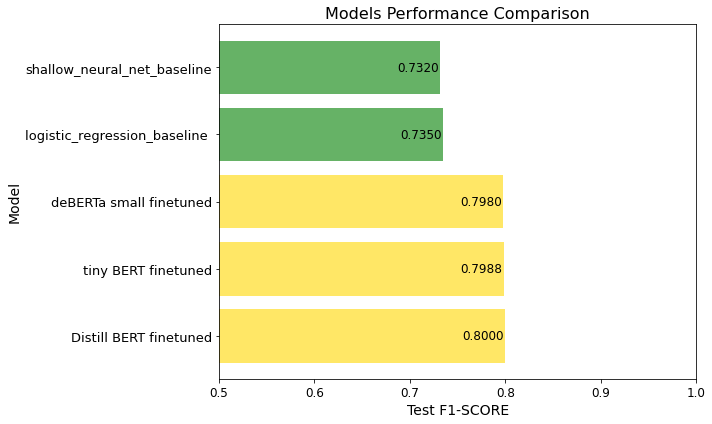

In [46]:

#TEST F1-SCORE

results = {"logistic_regression_baseline " : 0.735,
           "shallow_neural_net_baseline" : 0.732,
           "Distill BERT finetuned" : 0.8,
            "deBERTa small finetuned" : 0.798,
            "tiny BERT finetuned" : 0.7988}


sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*sorted_results)

cmap = plt.cm.get_cmap('rocket', len(models))

plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies, color=["gold", "gold", "gold", "green", "green"], alpha=0.6)

for bar, value in zip(bars, accuracies):
    plt.text(bar.get_width() - 0.002, bar.get_y() + bar.get_height()/2, f'{value:.4f}', color='black', va='center', ha='right', fontsize=12)

plt.xlabel('Test F1-SCORE', fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.xlim(0.5, 1)
plt.title('Models Performance Comparison', fontsize=16)

plt.tight_layout()
plt.show()

### Submit predictions

In [40]:
test_df = pd.read_csv("/kaggle/input/cleaned-nlp-tweets/cleaned_test.csv").fillna("missing")

test_df.head()

,id,text_cleaned
0,0,happened terrible car crash
1,2,heard different cities stay safe everyone
2,3,forest fire spot pond geese fleeing across street cannot save
3,9,apocalypse lighting
4,11,typhoon soudelor kills china taiwan


In [41]:
bert_predictions = tf.round(tf.sigmoid(bert_classifier.predict(test_df["text_cleaned"])))
debert_predictions = tf.round(tf.sigmoid(deberta_classifier.predict(test_df["text_cleaned"])))
tiny_bert_predictions = tf.argmax(tf.sigmoid(tiny_bert_classifier.predict(test_df["text_cleaned"])), axis=1)


  3/102 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step

W0000 00:00:1711984947.446501      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [46]:

bert_submission = pd.DataFrame({"id" : test_df["id"],
                                "target" : bert_predictions.numpy().flatten()})

deberta_submission =  pd.DataFrame({"id" : test_df["id"],
                                "target" : debert_predictions.numpy().flatten()})


tiny_bert_submission =  pd.DataFrame({"id" : test_df["id"],
                                "target" : tiny_bert_predictions.numpy().flatten()})



bert_submission.to_csv("bert_submission.csv", index=False)
deberta_submission.to_csv("deberta_submission.csv", index=False)
tiny_bert_submission.to_csv("tiny_bert_submission.csv", index=False)

### Kaggle score
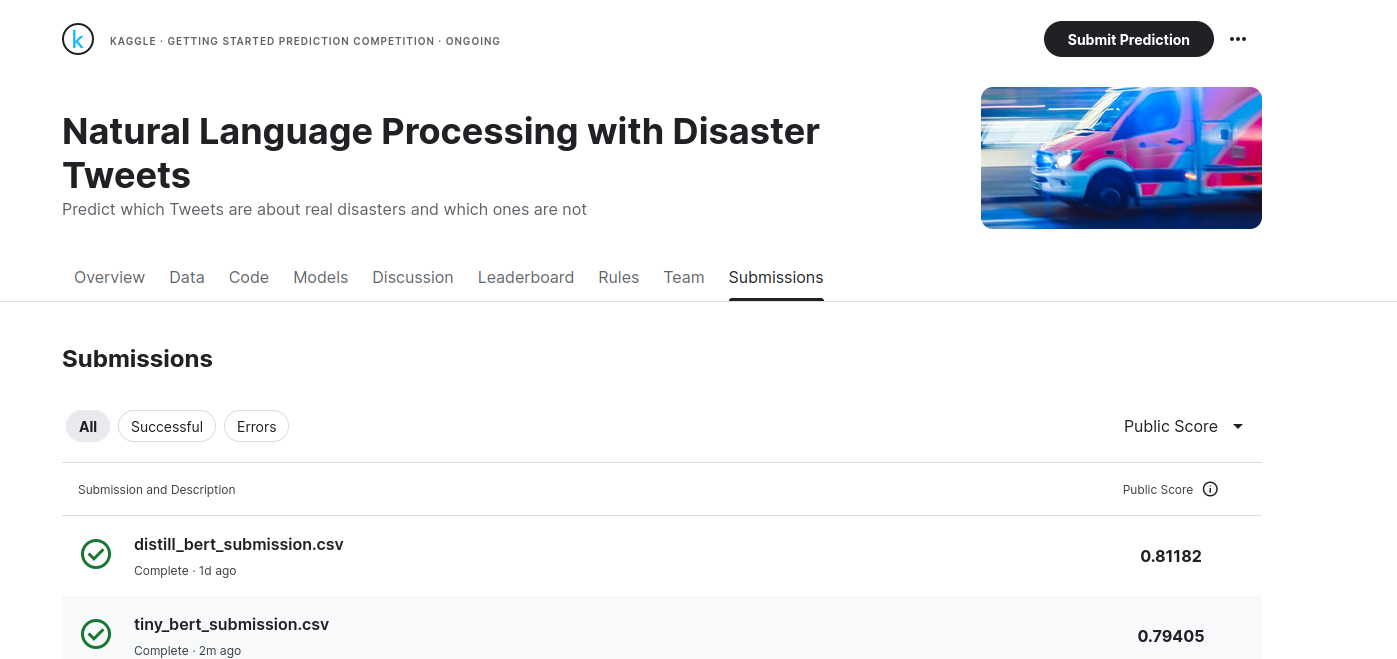